In [102]:
import sys
import numpy as np
from numpy.testing import assert_almost_equal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,PillowWriter
from IPython import display
import h5py
import pickle
# from copy import deepcopy

import argparse
from argparse import ArgumentParser

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# sys.path.append('/Users/chenwei/Desktop/Github/RPE/GSAE_source/GSAE/gsae/data_processing/')
from gsae.models.gsae_model import GSAE
from gsae.data_processing.utils import dot2adj
from gsae.data_processing.create_splits import split_data

from gsae.scattering.scattering import transform_dataset, get_normalized_moments
from gsae.utils import eval_metrics

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import phate


In [233]:
# load dataset generated by Multistrand
def loadtrj(f,FINAL_STRUCTURE,type):
    """load text data and split it into individual trajectory 
    with seperated structure, time, and energy

    Args:
        f: text file with trajectory dp notation, time, energy
            eg. '..((((....)))).', 't=0.000000103', 'seconds, dG=  0.26 kcal/mol\n'
        FINAL_STRUCTURE: final state structure, eg. "..((((....))))."
        type: 'Single' or 'Multiple' mode
    Returns:
        [list]: dot-parenthesis notation, time floats, energy floats
            eg. ['...............', 0.0, 0.0]
    """
    TRAJ=[];i=0;SIM=[]
    for s in f:
        i+=1
        if i>4: # remove headers
            ss = s.split(" ",3)
            s_dotparan=ss[0] # dp notation
            s_time = float(ss[1].split("=",1)[1]) # simulation time
            s_energy = float(ss[3].split("=")[1].split("kcal")[0]) # energy
            TRAJ.append([s_dotparan,s_time,s_energy])

            if type == "Single":
                if s_dotparan == FINAL_STRUCTURE: # split to individual trajectory
                    SIM.append(TRAJ)
                    TRAJ = []
    if type == "Multiple":
        SIM = TRAJ
    return SIM

In [91]:
# convert dot-parenthesis notation to adjacency matrix in a single trajectory
def sim_adj(sim):

    adj_mtr = []
    sim_G = np.array([])
    sim_T = np.array([])
    
    for s in sim:
        sim_T = np.append(sim_T,s[1]) # get time array
        sim_G = np.append(sim_G,s[2]) # get energy array
        
        adj = dot2adj(s[0])
        adj_mtr.append(adj)
    adj_mtr = np.array(adj_mtr) # get adjacency matrix
    
    sim_HT = np.concatenate([np.diff(sim_T),[0]])
    
    return adj_mtr,sim_T,sim_G,sim_HT

In [4]:
# load training and test data
def load_trte(train_data,test_data,
              batch_size=32,gnn=False,subsize=None,lognorm=False):

    train_adjs = train_data[0]
    train_coeffs = train_data[1]
    train_energies = train_data[2]
    
    test_adjs = test_data[0]
    test_coeffs = test_data[1]
    test_energies = test_data[2]

    if lognorm:
        # shift
        train_coeffs +=  np.abs(train_coeffs.min()) + 1
        test_coeffs += np.abs(train_coeffs.min()) + 1
        
        # log
        train_coeffs = np.log(train_coeffs)
        test_coeffs = np.log(test_coeffs)


    if gnn:
        train_diracs = torch.eye(train_adjs.shape[-1]).unsqueeze(0).repeat(train_adjs.shape[0],1,1)
        train_tup = (torch.Tensor(train_diracs),
                    torch.Tensor(train_adjs),
                    torch.Tensor(train_energies))
    else:
        train_tup = (torch.Tensor(train_coeffs),
                    torch.Tensor(train_energies))



    if gnn:
        test_diracs = torch.eye(test_adjs.shape[-1]).unsqueeze(0).repeat(test_adjs.shape[0],1,1)
        test_tup = (torch.Tensor(test_diracs),
                    torch.Tensor(test_adjs),
                    torch.Tensor(test_energies))

    else:
        test_tup = (torch.Tensor(test_coeffs), 
                    torch.Tensor(test_adjs), 
                    torch.Tensor(test_energies))
        
    #################
    # SUBSET DATA 
    #################tre
    if subsize != None:
        train_tup, _ = eval_metrics.compute_subsample(train_tup, subsize)
        test_tup, _ = eval_metrics.compute_subsample(test_tup, subsize)


    train_dataset = torch.utils.data.TensorDataset(*train_tup)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True)

    return train_loader, train_tup, test_tup


In [5]:
# calulate the occupancy density of each state
def adj_uniq_occp(states):
    """load adjacency matrix and calculate the occupancy density of each state
    Args:
        states: adjacency matrix
    Returns:
        indices,density: indices of unique states, occupancy density of each state
    """
    _, indices, counts = np.unique(states,axis=0,return_index=True,return_counts=True)
    counts = counts[np.argsort(indices)]
    indices = np.sort(indices)
    return indices, counts/counts.sum()

In [127]:
# calulate the time fraction of each state
def time_frac(SIM_adj,SIM_adj_uniq,SIM_HT):
    """load time array and calculate the time fraction of each state
    Args:
        SIM_adj,SIM_adj_uniq,SIM_HT
    Returns:
        time fractions: time fraction of each unique state
    """
    time_count = np.zeros(len(SIM_adj_uniq))
    
    for i in range(len(SIM_adj_uniq)):
        for j in range(len(SIM_adj)):
            if np.array_equal(SIM_adj_uniq[i],SIM_adj[j]):
                time_count[i] += SIM_HT[j]  
                
    time_fract = time_count/time_count.sum()
    
    # assert time_count.sum() == SIM_HT.sum(), "Time counts are not equal to total time."
    # assert time_fract.sum() == 1, "Total time fraction is not equal to 1."

    assert_almost_equal(time_count.sum(),SIM_HT.sum(),err_msg='Time counts are not equal to total time.')
    assert_almost_equal(time_fract.sum(),1,err_msg='Total time fraction is not equal to 1.')

    return time_count, time_fract

## 1. Import/generate Data

### 1. Load simulated data from Mulistrand

In [7]:
# load text file
f = open('./data/I1_10000sim.txt', 'r')
# define absorbing (final) state structure
sim_num = 10000
FINAL_STRUCTURE = "..((((....))))."

""" Dimenstions of SIM list 
SIM: [[sim1], [sim2], ...]
sim: [[state1], [state2], ...]
state: [structure, time, energy]
"""
SIM = loadtrj(f,sim_num,FINAL_STRUCTURE)
len(SIM)

10000

### 2. Convert dot-paren to adjacency matrix

In [138]:
# convert dot-parenthesis to adjecency matrix
""" Dimenstions of SIM_adj list 
SIM_adj: N*m*m
    N: number of states in the trajectory
    m: number of nucleotides in the state (strand)
"""
# convert single simulations
data = SIM[1]
SIM_adj,SIM_T,SIM_G,SIM_HT = sim_adj(data)
assert min(SIM_G) == SIM_G[-1], "Final state is not the minimum energy state."
SIM_adj.shape,SIM_HT.shape,SIM_T.shape,SIM_G.shape

# convert dot-parenthesis to adjecency matrix
""" Dimenstions of SIM_adj list 
SIM_adj: N*m*m
    N: number of states in the trajectory
    m: number of nucleotides in the state (strand)
"""

# # convert all simulations
# SIMS_adj=[]; SIMS_T=[]; SIMS_G=[]; SIMS_HT=[]
# for i in range(len(SIM)):
#     data = SIM[i]
#     SIM_adj,SIM_T,SIM_G,SIM_HT = sim_adj(data)
#     assert min(SIM_G) == SIM_G[-1], "Final state is not the minimum energy state."
#     SIMS_adj.append(SIM_adj); SIMS_T.append(SIM_T); SIMS_G.append(SIM_G); SIMS_HT.append(SIM_HT)

# SIMS_adj = np.concatenate((SIMS_adj),axis=0)
# SIMS_G = np.concatenate((SIMS_G),axis=0)
# SIMS_T = np.concatenate((SIMS_T),axis=0)
# SIMS_HT = np.concatenate((SIMS_HT),axis=0)


((507, 15, 15), (507,), (507,), (507,))

In [139]:
# get unique states adjacency matrix with their occupancy density
# get unique energy, and time
indices, occ_density = adj_uniq_occp(SIM_adj)

SIM_adj_uniq = SIM_adj[indices]
SIM_G_uniq = SIM_G[indices]
SIM_T_uniq = SIM_T[indices]
SIM_HT_uniq = SIM_HT[indices]
SIM_adj_uniq.shape, SIM_G_uniq.shape,SIM_T_uniq.shape,SIM_HT_uniq.shape

((21, 15, 15), (21,), (21,), (21,))

### 3. Get time counts and its fraction 

In [228]:
time_count,time_fract = time_frac(SIM_adj,SIM_adj_uniq,SIM_HT)

In [231]:
# find the structure consuming the most of time
data[indices[time_fract.argmax()]]

['((((....))))...', 8e-08, -1.5]

### 4. Convert adjacency matrix scattering coefficients

In [142]:
# convert all states
scat_coeff_array = transform_dataset(SIM_adj)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar = norm_scat_coeffs
SIM_scar.shape

100%|██████████| 507/507 [00:00<00:00, 7271.94it/s]


(507, 1200)

In [143]:
# convert only unique states to get unique scattering
scat_coeff_array = transform_dataset(SIM_adj_uniq)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array).squeeze()
SIM_scar_uniq = norm_scat_coeffs
SIM_scar_uniq.shape

# # get unique scattering structure for all states
# SIM_scar_uniq = SIM_scar[indices]
# SIM_scar_uniq.shape

100%|██████████| 21/21 [00:00<00:00, 5631.38it/s]


(21, 1200)

### 5. Split data into tranning and test sets

In [144]:
"""Shape of split data
    train_data: [tr_adjs, tr_coeffs, tr_energies]
    test_data: [te_adjs, te_coeffs, te_energies]
"""
train_data,test_data = split_data(SIM_adj,SIM_scar,SIM_G)

In [145]:
(np.unique(train_data[1],axis=0)).shape, train_data[1].shape,test_data[1].shape

((18, 1200), (354, 1200), (153, 1200))

### 6. Train loader

In [146]:
"""Structure of train_tup when gnn=False
    train_tup: [train_coeffs,train_energy] 
"""
train_loader, train_tup, test_tup = load_trte(train_data,test_data,
                                              batch_size=16)
train_tup[0].shape, test_tup[0].shape, train_loader.batch_size

(torch.Size([354, 1200]), torch.Size([153, 1200]), 16)

## 2. Load Model

In [147]:
# set up hyperparameters

input_dim = train_tup[0].shape[-1]
len_epoch = len(train_loader)

hparams = {
    'input_dim':  input_dim,
    'bottle_dim': 25,
    'hidden_dim': 400,
    
    'len_epoch': len_epoch,
    'learning_rate': 0.0001,
    'max_epochs': 80,
    'n_gpus': 0,
    'batch_size': 16,
    
    'alpha':1.0,
    'beta':0.0001,

}

In [148]:
hparams = argparse.Namespace(**hparams)

In [149]:
hparams.len_epoch

23

In [150]:
model = GSAE(hparams)

In [151]:
print(model)

GSAE(
  (fc11): Linear(in_features=1200, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=1200, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)


## 3. Train Model

In [152]:
trainer = pl.Trainer.from_argparse_args(hparams,
                                        max_epochs=hparams.max_epochs,
                                        gpus=hparams.n_gpus,
                                        )
trainer.fit(model=model,
            train_dataloader=train_loader,
            )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name   | Type        | Params
---------------------------------------
0 | fc11   | Linear      | 480 K 
1 | bn11   | BatchNorm1d | 800   
2 | fc12   | Linear      | 160 K 
3 | bn12   | BatchNorm1d | 800   
4 | fc21   | Linear      | 10 K  
5 | fc22   | Linear      | 10 K  
6 | fc3    | Linear      | 10 K  
7 | fc4    | Linear      | 481 K 
8 | regfc1 | Linear      | 520   
9 | regfc2 | Linear      | 21    


Epoch 0:  87%|████████▋ | 20/23 [00:00<00:00, 113.27it/s, loss=3.219, v_num=36]

/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/chenwei/miniforge3/envs/GSAE/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


Epoch 79: 100%|██████████| 23/23 [00:00<00:00, 104.78it/s, loss=0.228, v_num=36]


1

In [155]:
# save the trained model
# from data I1_10000sim.txt SIM[1]
filename = "models/I1_10000_SIM1_model.pickle"
pickle.dump(model, open(filename, 'wb'))
print('Trained model saved.')


Trained model saved.


## 3. Load Pretrained Models

In [182]:
# filename = "/Users/chenwei/Desktop/Github/GSAE/saved_models/GSAE_trained_model_seq3"
filename = "/Users/chenwei/Desktop/Github/RPE/code/models/I1_10000_SIM1_model.pickle"
model = pickle.load(open(filename, 'rb'))
model

GSAE(
  (fc11): Linear(in_features=1200, out_features=400, bias=True)
  (bn11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc12): Linear(in_features=400, out_features=400, bias=True)
  (bn12): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=400, out_features=25, bias=True)
  (fc22): Linear(in_features=400, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=1200, bias=True)
  (regfc1): Linear(in_features=25, out_features=20, bias=True)
  (regfc2): Linear(in_features=20, out_features=1, bias=True)
)

## 4. Get Embeddings

In [183]:
# without duplicates
with torch.no_grad():
        data_embed = model.embed(torch.Tensor(SIM_scar_uniq))[0]

# # with duplicates
# with torch.no_grad():
#         data_tensor =  (torch.Tensor(SIM_scar),
#                         torch.Tensor(SIM_G))
#         data_embed = model.embed(data_tensor[0])[0]

# data_embed.shape

In [185]:
""" Save embeded data to npy file
"""
# save GSAE embeded data
with open('data/I1_sim1_embed_uniq.npy', 'wb') as f:
    np.savez(f,data_embed=data_embed)

npyfile0 = np.load("data/I1_sim1_embed_uniq.npy")
npyfile0.files
data_embed = npyfile0["data_embed"]
data_embed.shape

(21, 25)

In [ ]:
# """save embeded data to h5 file
# """
# def main():
#     hf = h5py.File("data/I1_0_embed.h5", "w")
#     hf.create_dataset("data_embed", data=data_embed)
#     hf.close

# if __name__ == "__main__":
#     main()

## 5. Visualize

### 1. PCA Vis

In [186]:
pca_coords = PCA(n_components=3).fit_transform(data_embed)
pca_coords.shape

(21, 3)

In [190]:
""" Save plot data to npy file
"""  
# save pca coordinates, energy, time data to npy file for Julia plot
with open('data/I1_sim1_pca_uniq.npy', 'wb') as f:
    np.savez(f,pca=pca_coords,energy=SIM_G_uniq,time_HT=SIM_HT_uniq,
                  occp = occ_density,time_count=time_count,
                  time_fract=time_fract)

npyfile = np.load("data/I1_sim1_pca_uniq.npy")
npyfile.files

['pca', 'energy', 'time_HT', 'occp', 'time_count', 'time_fract']

In [191]:
X = npyfile["pca"][:,0]
Y = npyfile["pca"][:,1]
Z = npyfile["pca"][:,2]

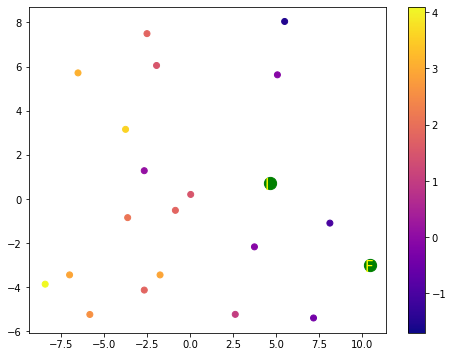

In [192]:
# PCA: 2 components
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(X, Y, 
          c=npyfile["energy"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [X[0],X[-1]]
y = [Y[0],Y[-1]]
plt.scatter(x,y,s=150, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.3,y[i]-0.3),fontsize=15,c="yellow")

In [ ]:
# PCA: 2 components

fig,ax = plt.subplots(figsize=(8,6))
ax = plt.axes(projection ="3d")

im = ax.scatter3D(npyfile["pca1"],
          npyfile["pca2"],
          npyfile["energy"],
          c=npyfile["energy"], 
          cmap='plasma')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Energy")
plt.colorbar(im)

annotations=["I","F"]
x = [npyfile["pca1"][0],npyfile["pca1"][-1]]
y = [npyfile["pca2"][0],npyfile["pca2"][-1]]
z = [npyfile["energy"][0], npyfile["energy"][-1]]
ax.scatter(x,y,z,s=150,c="green",alpha=1)


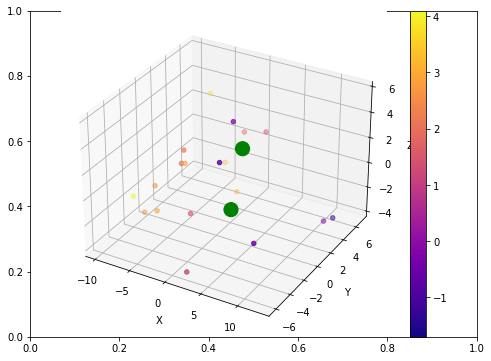

In [ ]:
# PCA: 3 components

fig,ax = plt.subplots(figsize=(8,6))
ax = plt.axes(projection ="3d")

im = ax.scatter3D(npyfile["pca1"],
          npyfile["pca2"],
          npyfile["pca3"],
          c=npyfile["energy"],
          cmap='plasma')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(im)

annotations=["I","F"]
x = [npyfile["pca1"][0],npyfile["pca1"][-1]]
y = [npyfile["pca2"][0],npyfile["pca2"][-1]]
z = [npyfile["pca3"][0], npyfile["pca3"][-1]]
ax.scatter(x,y,z,s=200,c="green",alpha=1)

### 2. PHATE Vis

In [194]:
npyfile0 = np.load("data/I1_sim1_embed_uniq.npy")
data_gsae = npyfile0["data_embed"]
data_gsae.shape

(21, 25)

In [195]:
data_gsae = data_embed
data_gsae.shape

(21, 25)

In [196]:
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(data_gsae)
Y_phate.shape

Calculating PHATE...
  Running PHATE on 21 observations and 25 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 17
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


(21, 2)

In [197]:
""" Save plot data to npy file
"""  
# save pca coordinates, energy, time data to npy file for Julia plot
with open('data/I1_sim1_phate_uniq.npy', 'wb') as f:
    np.savez(f,phate=Y_phate,energy=SIM_G_uniq,time_HT=SIM_HT_uniq,
             occp=occ_density,time_count=time_count,
             time_fract=time_fract)

npyphate = np.load("data/I1_sim1_phate_uniq.npy")
Y_phate = npyphate["phate"]
Y_phate.shape, npyphate.files

((21, 2), ['phate', 'energy', 'time_HT', 'occp', 'time_count', 'time_fract'])

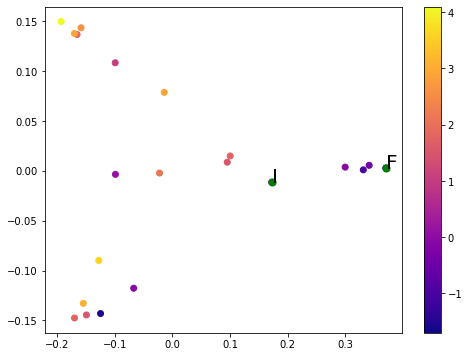

In [198]:
fig,ax = plt.subplots(figsize=(8,6))
im = ax.scatter(Y_phate[:,0],
          Y_phate[:,1],
          c=npyphate["energy"], 
          cmap='plasma',
        )

plt.colorbar(im)

annotations=["I","F"]
x = [Y_phate[:,0][0],Y_phate[:,0][-1]]
y = [Y_phate[:,1][0],Y_phate[:,1][-1]]
plt.scatter(x,y,s=50, c="green", alpha=1)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i],y[i]),fontsize=20,c="black")

In [67]:
aa = "..(((..))).."

In [68]:
tadj1 = dot2adj(aa)
tadj1

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [82]:
bb = "..(((..))).."

In [83]:
tadj2 = dot2adj(bb)
tadj2

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [84]:
np.array_equal(tadj1,tadj2)

True

In [87]:
scat_1 = transform_dataset(tadj1)
scat_1.shape

100%|██████████| 12/12 [00:00<00:00, 3951.30it/s]


(12, 12, 240)

In [88]:
scat_2 = transform_dataset(tadj2)
scat_2.shape

100%|██████████| 12/12 [00:00<00:00, 5363.56it/s]


(12, 12, 240)

In [89]:
np.array_equal(scat_1,scat_2)

True

In [92]:
scat_coeff_array1 = transform_dataset(tadj1)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array1).squeeze()
scat_coeff_array1 = norm_scat_coeffs
scat_coeff_array1

100%|██████████| 12/12 [00:00<00:00, 4091.34it/s]


array([[ 0.02083333,  0.22916667,  0.02083333, ...,  7.090911  ,
         7.09091   ,  7.09091   ],
       [ 0.125     ,  0.02083333,  0.125     , ...,  7.090911  ,
         7.09091   ,  7.09091   ],
       [ 0.02083333,  0.09027779,  0.02083333, ...,  7.09091   ,
         7.090909  ,  7.090909  ],
       ...,
       [ 0.02083333,  0.02083333,  0.09027777, ...,  7.090906  ,
         7.09091   ,  7.090909  ],
       [ 0.02083333,  0.02083333,  0.02083333, ..., -3.        ,
         7.09091   , -3.        ],
       [ 0.02083333,  0.02083333,  0.02083333, ...,  7.090911  ,
         7.09091   ,  7.09091   ]], dtype=float32)

In [93]:
scat_coeff_array2 = transform_dataset(tadj2)
norm_scat_coeffs = get_normalized_moments(scat_coeff_array2).squeeze()
scat_coeff_array2 = norm_scat_coeffs
scat_coeff_array2

100%|██████████| 12/12 [00:00<00:00, 4987.78it/s]


array([[ 0.02083333,  0.22916667,  0.02083333, ...,  7.090911  ,
         7.09091   ,  7.09091   ],
       [ 0.125     ,  0.02083333,  0.125     , ...,  7.090911  ,
         7.09091   ,  7.09091   ],
       [ 0.02083333,  0.09027779,  0.02083333, ...,  7.09091   ,
         7.090909  ,  7.090909  ],
       ...,
       [ 0.02083333,  0.02083333,  0.09027777, ...,  7.090906  ,
         7.09091   ,  7.090909  ],
       [ 0.02083333,  0.02083333,  0.02083333, ..., -3.        ,
         7.09091   , -3.        ],
       [ 0.02083333,  0.02083333,  0.02083333, ...,  7.090911  ,
         7.09091   ,  7.09091   ]], dtype=float32)

In [94]:
np.array_equal(scat_coeff_array1,scat_coeff_array2)

True

In [2]:
import numpy as np
fname_data = "/Users/chenwei/Desktop/Github/RPE/code/data/helix_assos/assos_PT0_1sim_20C_51_1985epoch.npz"
npyfile = np.load(fname_data)
npyfile.files

['SIM_adj',
 'SIM_scar',
 'SIM_G',
 'SIM_HT',
 'SIM_adj_uniq',
 'SIM_scar_uniq',
 'SIM_G_uniq',
 'SIM_HT_uniq',
 'SIM_dict',
 'occp',
 'data_embed',
 'coord_id',
 'pca_coords',
 'pca_all_coords',
 'phate_coords',
 'phate_all_coords']

In [6]:
npyfile["SIM_dict"][0][1]

'0.0'